# Coleta de base

In [1]:
!pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

In [3]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('https://raw.githubusercontent.com/Muniz97/Federal-road-accidents---Brazil/main/2%20-%20Statistic/Federal_Accidents_Statistic.csv', sep = ',', encoding='ISO-8859-1')

# Treino e teste

Vamos dividir nossa amostra em base de treino e teste; isso serve para ensinar o modelo e, em seguida, avaliá-lo:

1. **Treino**: Maior parte da amostra original, serve para treinar o modelo, fazê-lo aprender a lidar com os dados;
2. **Teste**: Menor parte da amostra original, após o aprendizado do modelo, o mesmo realizará a predição na base teste, com dados dos quais ele não teve contato, e assim avaliamos seu desempenho.



Algumas variáveis precisam ser removidas, pois não têm lógica para serem consideradas no modelo. São elas:

*    **id**: A identificação da ocorrência não é necessária e nem deve ser utilizada como feature;
*    **data_inversa**: Já existem 3 campos derivados;
*    **horario**: Ambíguo com os campos hora e minutos;
*    **classificacao_acidente**: A ideia é estimar quais ocorrências podem levar à fatalidade. Utilizar uma variável em que uma de suas categorias já expresse isso seria redundante;
*    **feridos**: A feature é apenas a soma dos feridos_leves e feridos_graves;
*    **mortos**: Ambíguo em relação à target;
*    **regional**: Tem a mesma função de uf;
*    **uop**: Tem a mesma função de delegacia;
*    **latitude e longitude**: Existem diversos outros campos para localização, como uf, região, município e br.

In [4]:
# Separando variáveis explicativas e variável resposta

# Variáveis explicativas
X = df.drop(['id','data_inversa','horario','classificacao_acidente','feridos','mortos','regional','uop','ano_mes','obitos','latitude','longitude'], axis = 1)

# Variável resposta (binária)
y = df['obitos']

Após remover as variáveis que não fazem sentido para o estudo se faz necessário separar as bases em treino e teste.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1337, stratify = y)

Alguns pontos sobre a maneira que realizei o train_test_split:

*   **Test_size**: Tamanho de 20% para teste me parece um número aceitavel visto que estamos lidando com uma amostra grande, com 184.550 ocorrências, dado isso a base teste possui 36.910 observações;
*   **Random_state**: Para que mantenha a separação e que possa ser replicado;
*   **Stratify**: Como estou lidando com dados bastante desbalanceados, manter a proporção ajuda ao modelo ser treinado e avaliado com dados que representam a realidade. Lembrando que a proporção por ano, dos últimos 3 anos são de 7%.



# Pré-Processamento dos dados

Como vimos anteriormente as features uf, br, município e causa_acidente possuem muitas categorias e transformá-las via one-hot ou get_dummies aumentaria demais o número de colunas.

Dado isso, utilizarei o '**CatBoostEncoder**', feito para otimizar o tratamento de variáveis categóricas no estilo CatBoost, que pode ser utilizado em outros modelo de machine learning([documentação](https://contrib.scikit-learn.org/category_encoders/catboost.html)).



In [6]:
# Separação de variáveis categóricas
features_cat = ['dia_semana','uf','br','municipio','causa_acidente','tipo_acidente','fase_dia','sentido_via','condicao_metereologica','tipo_pista','uso_solo','delegacia','regiao']
features_num = ['km','pessoas','feridos_leves','feridos_graves','ilesos','ignorados','veiculos','ano','mes','dia','horas','minutos']

In [7]:
# Variaveis Categóricas
encoder = CatBoostEncoder(cols = features_cat)
x_train_encoder = encoder.fit_transform(x_train,y_train)

In [8]:
# Variaveis Númericas
scaler = StandardScaler()
x_train_encoder[features_num] = scaler.fit_transform(x_train_encoder[features_num])

In [9]:
# Base de Teste
x_test_encoder = encoder.transform(x_test)
x_test_encoder[features_num] = scaler.transform(x_test_encoder[features_num])

In [10]:
# Junta as bases tratadas
train_encoder = pd.concat([x_train_encoder,y_train], axis = 1)
test_encoder = pd.concat([x_test_encoder,y_test], axis = 1)

# Gerar os arquivos a parte
train_encoder.to_csv('train_encoder.csv', index = False)
test_encoder.to_csv('test_encoder.csv', index = False)

In [11]:
# Númerode linhas e colunas
print(f'Número de observações: {train_encoder.shape[0]}')
print(f'Número de variáveis: {train_encoder.shape[1]}')

Número de observações: 147640
Número de variáveis: 26


# Oversampling

**Oversampling** é uma técnica que aumenta o número de observações, dado as classes que possuem menor frequência, através da criação de dados sintéticos com referência nos dados já existentes da menor classe. Isso faz com que o algoritmo tenha mais dados para treino e assim entender e aprender melhor com o que está trabalhando.

Uitlizaremos apenas na base treino, separada da base treino original e avaliaremos o modelo adestrado nos dados de teste.

## SMOTE

**SMOTE** é um dos diversos algoritmos disponíveis para criar dados sintéticos. SMOTE utiliza interpolação dos pontos mais próximos, gerando assim mais dados para a classe minoritária.

In [12]:
# Trás o algoritmo
smote = SMOTE()

# Aplicar o fit na base treino
x_train_smote, y_train_smote = smote.fit_resample(x_train_encoder, y_train)

# Unifica as bases de smote
train_smote = pd.concat([x_train_smote,y_train_smote], axis = 1)

Agora vamos comparar a base de treino com dados sintéticos e sem dados sintéticos.

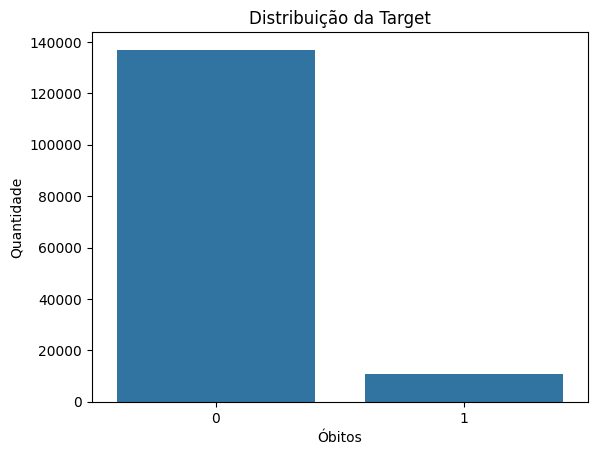

In [13]:
# Distribuição da Target sem oversampling
sns.countplot(data = pd.concat([x_train_encoder, y_train], axis = 1), x = 'obitos')
plt.title('Distribuição da Target')
plt.xlabel('Óbitos')
plt.ylabel('Quantidade')
plt.show()

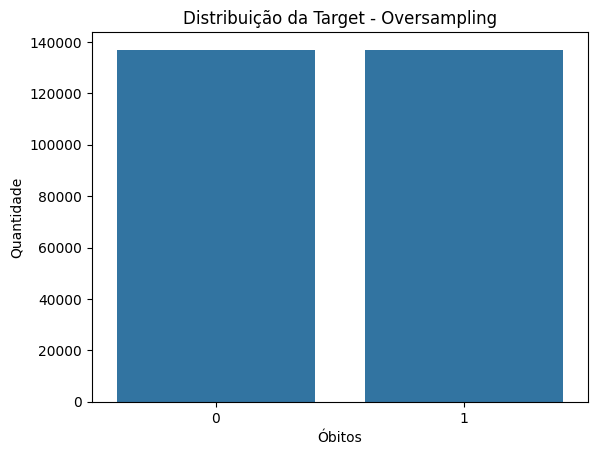

In [14]:
# Distribuição da Target com oversampling
sns.countplot(data= pd.concat([x_train_smote,y_train_smote], axis = 1), x = 'obitos')
plt.title('Distribuição da Target - Oversampling')
plt.xlabel('Óbitos')
plt.ylabel('Quantidade')
plt.show()

Note que agora os dados estão balanceados.

In [15]:
# Númerode linhas e colunas
print(f'Número de observações: {train_smote.shape[0]}')
print(f'Número de variáveis: {train_smote.shape[1]}')

Número de observações: 273948
Número de variáveis: 26


Separarei a base individualmente.

In [16]:
train_smote.to_csv('train_smote.csv', index = False)
train_smote.head()

,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,uso_solo,pessoas,feridos_leves,feridos_graves,ilesos,ignorados,veiculos,delegacia,ano,mes,dia,horas,minutos,regiao,obitos
0,0.072243,0.072243,0.072243,-0.043891,0.072243,0.072243,0.072243,0.072243,0.072243,0.072243,0.072243,0.072243,0.293954,-0.793835,-0.451818,0.610771,-0.334977,1.847050,0.072243,1.300339,0.808827,-0.526396,1.488534,-0.532127,0.072243,1
1,0.072243,0.072243,0.072243,-0.451870,0.072243,0.072243,0.072243,0.536122,0.536122,0.536122,0.072243,0.536122,-0.684358,-0.793835,-0.451818,-0.636591,1.731284,-0.909917,0.072243,-1.182679,0.506402,1.296117,1.652307,-1.391066,0.072243,0
2,0.036122,0.536122,0.072243,-0.285575,0.072243,0.072243,0.072243,0.072243,0.357414,0.357414,0.036122,0.357414,-0.684358,-0.793835,-0.451818,-0.636591,1.731284,-0.909917,0.072243,-1.182679,-1.610572,-0.868117,0.669669,-0.245814,0.536122,0
3,0.536122,0.072243,0.072243,-0.251872,0.072243,0.072243,0.072243,0.036122,0.268061,0.072243,0.536122,0.268061,-0.684358,0.134408,-0.451818,-0.636591,-0.334977,-0.909917,0.072243,-1.182679,1.716101,1.296117,-0.149196,-1.391066,0.036122,0
4,0.024081,0.036122,0.036122,-1.086455,0.072243,0.072243,0.072243,0.024081,0.214449,0.072243,0.024081,0.072243,-0.684358,-0.793835,1.176677,-0.636591,-0.334977,-0.909917,0.072243,1.300339,-1.005722,-0.640303,-0.968061,0.326812,0.024081,0
